In [1]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import ipywidgets as widgets
from IPython import display

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys
sys.path.append('/h/ashlie/jupyter_helpers')
import plot_helper as ph

import os

In [3]:
objs = []

In [4]:
# time ms in msec, latency us in nsec.
base_path = '/h/ashlie/new-benchmark-dif-bufs-512'
op_types = [
    #'read',
    #'randread',
    'write',
    #'randwrite',
]
queue_sizes = [
    1,
    #2,
    #4,
    8,
    #16,
    #32,
    64,
    #128,
    #256,
    512,
    #1024,
    #2048,
    4096,
]
latf = '_lat.log'

devs = {
    #'spdk',
    #'spdk_delay',
    #'spdk_batch',
    #'spdk_delay_batch',
    #'spdk_optane',
    #'spdk_optane_delay',
    'spdk_optane_batch',
    #'spdk_optane_delay_batch',
    #'sync',
    #'sync_force_sync',
    #'sync_ramdisk',
}

blk_sizes = {
    512,
    1024,
    2048,
    4096,
}

# TODO(t-asmart): Make this easier to handle without having to clobber objs.
for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                objs.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev,
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    latf)
                })

# Total time in sec
total_time = 10
bytes_per_mb = 1024 ** 2

large_fig_dim = (15, 10.6)

In [5]:
# time ms in msec, latency us in nsec.
base_path2 = '/h/ashlie/new-benchmark-fio-no-sleep'
objs2 = []

# TODO(t-asmart): Make this easier to handle without having to clobber objs.
for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                objs2.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev + '_static',
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path2, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    latf)
                })

In [6]:
# time ms in msec, latency us in nsec.
base_path3 = '/h/ashlie/new-benchmark-dif-bufs-4096'
objs3 = []

# TODO(t-asmart): Make this easier to handle without having to clobber objs.
for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                objs3.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev + '_4096',
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path3, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    latf)
                })

In [7]:
objs = objs + objs2 + objs3

In [8]:
len(objs)

60

In [9]:
for obj in objs:
    obj['df'] = pd.read_csv(obj['filePath'], sep=',',
                            names=['io num', 'latency (ns)', 'block size', 'current queue depth', 'completion batch size'])

In [10]:
latVQd = {}
for op in op_types:
    latVQd[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        latVQd[op] = latVQd[op].append({
            'Device': obj['device'],
            'average latency (us)': obj['df']['latency (ns)'].mean() / 1000,
            'max queue depth': obj['queueSize'],
            'block size': int(obj['blockSize']),
        }, ignore_index=True)

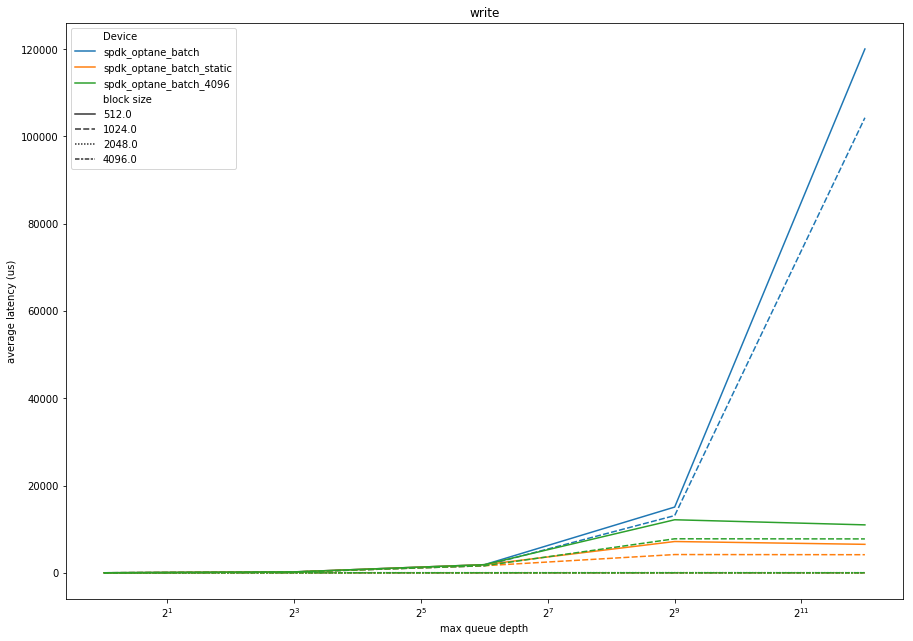

In [11]:
figLatVQd, axesLatVQd = plt.subplots(nrows=len(latVQd), ncols=1,
                                     figsize=(large_fig_dim[0], large_fig_dim[1] * len(latVQd)))
row = 0
for k, p in latVQd.iteritems():
    sns.lineplot(x='max queue depth', y='average latency (us)', data=p,
                 hue='Device', style='block size', ax=axesLatVQd)
    axesLatVQd.set_xscale('log', basex=2)
    axesLatVQd.set_title(k)
    row += 1

In [12]:
latVCqd = {}
for op in op_types:
    latVCqd[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        tmp = obj['df'].sample(n=500, random_state=42)
        tmp['Device'] = obj['device']
        tmp['latency (us)'] = tmp['latency (ns)'] / 1000
        tmp.drop(columns=['latency (ns)', 'io num', 'completion batch size'], inplace=True)
        latVCqd[op] = latVCqd[op].append(tmp)

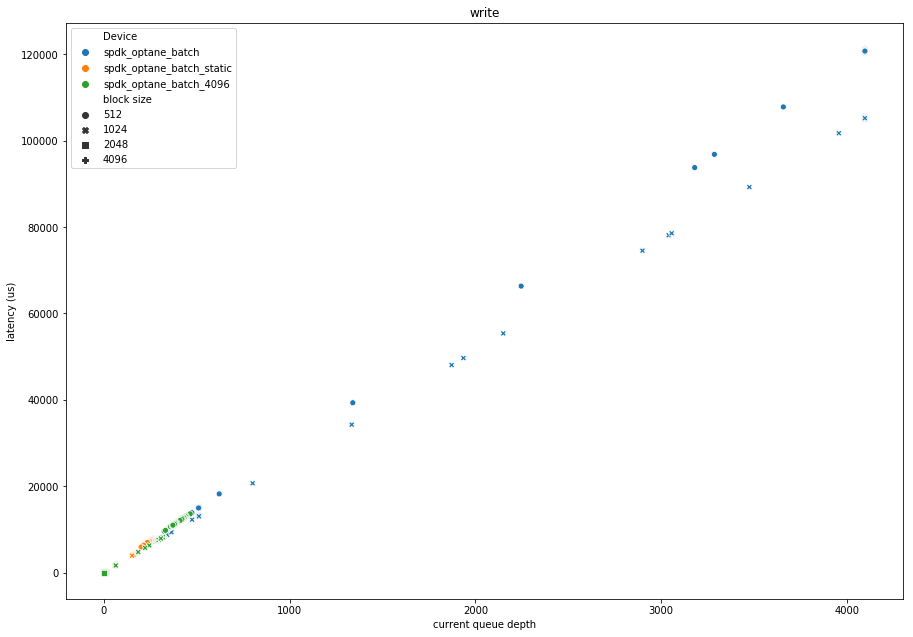

In [14]:
figLatVCqd, axesLatVCqd = plt.subplots(nrows=len(latVCqd), ncols=1,
                                       figsize=(large_fig_dim[0], large_fig_dim[1] * len(latVCqd)))
row = 0
for k, p in latVCqd.iteritems():
    sns.scatterplot(x='current queue depth', y='latency (us)', data=p,
                 hue='Device', style='block size', ax=axesLatVCqd)
    #axesLatVCQd[row].set_xscale('log', basex=2)
    axesLatVCqd.set_title(k)
    row += 1